In [63]:
import polars as pl
import pandas as pd
from tqdm import tqdm
import os
import json
import numpy as np
from catboost import CatBoostClassifier, CatBoostRanker, Pool, sum_models
from sklearn.utils import resample
from polimi.utils._inference import _inference
from ebrec.evaluation.metrics_protocols import *
from ebrec.utils._behaviors import sampling_strategy_wu2019
from polimi.utils._polars import reduce_polars_df_memory_size
from polimi.test.level_2_ensemble.build_model_predictions import require_subsampled_set, train_predict_model
from fastauc.fastauc.fast_auc import CppAuc
import os
import logging
from lightgbm import LGBMClassifier, LGBMRanker
from datetime import datetime
import argparse
import pandas as pd
import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing_extensions import List, Tuple, Dict, Type
import optuna
import polars as pl
from catboost import CatBoostClassifier, CatBoostRanker
from xgboost import XGBClassifier, XGBRanker
from polimi.utils._tuning_params import get_models_params
import gc
from polars import testing


In [64]:
drop_me = ['Category_auto_Pct',
           'Category_bibliotek_Pct',
           'Category_biler_Pct',
           'Category_dagsorden_Pct',
           'Category_ferie_Pct',
           'Category_forbrug_Pct',
           'Category_haandvaerkeren_Pct',
           'Category_horoskoper_Pct',
           'Category_incoming_Pct',
           'Category_krimi_Pct',
           'Category_musik_Pct',
           'Category_nationen_Pct',
           'Category_nyheder_Pct',
           'Category_om_ekstra_bladet_Pct',
           'Category_opinionen_Pct',
           'Category_penge_Pct',
           'Category_plus_Pct',
           'Category_podcast_Pct',
           'Category_services_Pct',
           'Category_video_Pct',
           'Category_vin_Pct',
           'EVENTPct',
           'Entity_EVENT_Present',
           'Entity_PER_Present',
           'LOCPct',
           'MISCPct',
           'MaxReadTime',
           'MaxScrollPercentage',
           'MedianReadTime',
           'MedianScrollPercentage',
           'MostFrequentCategory',
           'MostFrequentHour',
           'MostFrequentWeekday',
           'NegativePct',
           'NeutralPct',
           'NumArticlesHistory',
           'NumberDifferentCategories',
           'ORGPct',
           'PERPct',
           'PRODPct',
           'PctCategoryMatches',
           'PctNotDefaultArticles',
           'PctStrongNegative',
           'PctStrongNeutral',
           'PctStrongPositive',
           'PositivePct',
           'TotalReadTime',
           'age',
           'clicked_count_l_inf_impression',
           'endorsement_20h_articleuser_l_inf_articleuser',
           'endorsement_20h_articleuser_macd',
           'endorsement_10h_leak_macd',
           'entropy_impression_mean_JS',
           'entropy_impression_std_JS',
           'entropy_impression_topics_cosine',
           'entropy_impression_trendiness_score_3d_leak',
           'entropy_impression_trendiness_score_category',
           'gender',
           'is_already_seen_article',
           'is_inside_window_1',
           'kurtosis_impression_article_delay_hours',
           'kurtosis_impression_endorsement_10h',
           'kurtosis_impression_endorsement_10h_leak',
           'kurtosis_impression_inview_count',
           'kurtosis_impression_mean_JS',
           'kurtosis_impression_mean_topic_model_cosine',
           'kurtosis_impression_std_JS',
           'kurtosis_impression_topics_cosine',
           'kurtosis_impression_total_read_time',
           'kurtosis_impression_trendiness_score_3d',
           'kurtosis_impression_trendiness_score_3d_leak',
           'kurtosis_impression_trendiness_score_5d',
           'kurtosis_impression_trendiness_score_category',
           'last_session_duration',
           'last_session_time_hour_diff',
           'lda_0_history_mean',
           'lda_0_history_weighted_mean',
           'lda_1_history_mean',
           'lda_1_history_weighted_mean',
           'lda_2_history_mean',
           'lda_2_history_weighted_mean',
           'lda_3_history_mean',
           'lda_3_history_weighted_mean',
           'lda_4_history_mean',
           'lda_4_history_weighted_mean',
           'max_ner_item_knn_scores',
           'max_ner_svd_scores',
           'max_topic_model_cosine',
           'mean_ner_item_knn_scores',
           'mean_ner_svd_scores',
           'mean_prev_sessions_duration',
           'mean_topic_model_cosine',
           'mean_topic_model_cosine_l_inf_article',
           'mean_topic_model_cosine_l_inf_impression',
           'mean_topic_model_cosine_l_inf_user',
           'mean_topic_model_cosine_minus_median_impression',
           'mean_topic_model_cosine_rank_impression',
           'mean_user_trendiness_score',
           'min_JS',
           'min_topic_model_cosine',
           'num_topics',
           'postcode',
           'sentiment_label_diversity_impression',
           'skew_impression_inview_count',
           'skew_impression_mean_topic_model_cosine',
           'skew_impression_std_JS',
           'skew_impression_topics_cosine',
           'skew_impression_total_pageviews/inviews',
           'skew_impression_trendiness_score_3d',
           'skew_impression_trendiness_score_3d_leak',
           'skew_impression_trendiness_score_5d',
           'skew_impression_trendiness_score_category',
           'std_impression_mean_JS',
           'std_impression_mean_topic_model_cosine',
           'std_impression_std_JS',
           'std_impression_topics_cosine',
           'std_impression_trendiness_score_3d',
           'std_impression_trendiness_score_3d_leak',
           'std_impression_trendiness_score_5d',
           'std_impression_trendiness_score_category',
           'std_topic_model_cosine',
           'topics_cosine_l_inf_user',
           'total_ner_item_knn_scores',
           'total_ner_svd_scores',
           'total_pageviews_minus_median_impression',
           'total_pageviews_rank_impression',
           'total_read_time_l_inf_impression',
           'total_read_time_minus_median_impression',
           'total_read_time_rank_impression',
           'trendiness_score_1d/5d',
           'weighted_mean_topic_model_cosine',
           'window_0_history_length',
           'window_1_history_length',
           'window_2_history_length',
           'window_3_history_length',
           'window_topics_score']

In [65]:
RANKER = False
MODEL_LIST = ['catboost_ranker', 'catboost_classifier', 'dcn', 'GANDALF','mlp', 'wd'] # light_gbm_classifier
original_dataset_path = '/home/ubuntu/dataset/ebnerd_small/train/behaviors.parquet'
HYBRID_WEIGHTS = [0.651223860703235, 0.006964258477371873, 0.009186862873165197, 0.06657633706463335, 0.26585853547326727, 0.00019014540832729132]
# level2_train_df=pl.read_parquet()
# level2_val_df=pl.read_parquet()

behaviors = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/behaviors.parquet')
history_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/history.parquet')
history_val = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/validation/history.parquet')
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/articles.parquet')


In [66]:
def prediction_feature_eng(df, models):
    '''
        Do feature engineering of the predictions
    '''
    df = df.with_columns(
        *[
            (pl.col(f'prediction_{model}')-pl.col(f'prediction_{model}').min().over('impression_id')) / 
            (pl.col(f'prediction_{model}').max().over('impression_id')-pl.col(f'normalized_prediction_{model}').min().over('impression_id'))
            for model in models
        ]
    )
    
    return df

In [67]:
def load_predictions(dir, model_list):
    model_name = model_list[0]
    print(f'Loading Predictions for {model_name}')
    merged_df = reduce_polars_df_memory_size(pl.read_parquet(dir + f'/{model_name}_predictions.parquet'), verbose=0)\
        .sort(by=['impression_id','article'])
    original_shape = merged_df.shape[0]
    for df in range(1, len(model_list)):
        model_name = model_list[df]
        print(f'Loading Predictions for {model_name}')
        model_predictions = reduce_polars_df_memory_size(pl.read_parquet(dir + f'/{model_name}_predictions.parquet'),verbose=0).sort(by=['impression_id','article'])
        testing.assert_frame_equal(merged_df.select(['impression_id','article','target']), 
                                   model_predictions.select(['impression_id','article','target']))
        merged_df = merged_df.with_columns(
            model_predictions[f'prediction_{model_name}'].alias(f'prediction_{model_name}')
        )
        assert original_shape == merged_df.shape[0]
        
    return merged_df

In [68]:
def preprocessing(df, path_features, hybrid_weights):
    # MODEL_LIST = ['catboost_ranker', 'catboost_classifier', 'light_gbm_classifier', 'mlp', 'GANDALF', 'wd', 'dcn']
    for model in MODEL_LIST:
        if model in ['mlp', 'GANDALF', 'wd', 'dcn']:
            df = df.with_columns(
                    pl.col(f'prediction_{model}').list.first()    
                )
    df = df.with_columns(
        *[
            ((pl.col(f'prediction_{model}')-pl.col(f'prediction_{model}').min().over('impression_id')) / 
            (pl.col(f'prediction_{model}').max().over('impression_id')-pl.col(f'prediction_{model}').min().over('impression_id'))).alias(f'normalized_prediction_{model}')
            for model in MODEL_LIST
        ]
        ).with_columns(
            *[((pl.col(f'prediction_{model}')-pl.col(f'prediction_{model}').min().over('article')) / 
            (pl.col(f'prediction_{model}').max().over('article')-pl.col(f'prediction_{model}').min().over('article'))).alias(f'art_norm_prediction_{model}')
            for model in MODEL_LIST]
        ).with_columns(
            *[(hybrid_weights[i] * pl.col(f'normalized_prediction_{MODEL_LIST[i]}')).alias(f'prediction_hybrid_{MODEL_LIST[i]}') for i in range(len(MODEL_LIST))]
        ).with_columns(
                pl.sum_horizontal([f"prediction_hybrid_{model}" for model in MODEL_LIST]).alias('prediction_hybrid')
        ).drop( [f'prediction_hybrid_{model}' for model in MODEL_LIST])

    df = df.with_columns(
            *[pl.col(f'prediction_{model}').mean().over('impression_id').alias(f'mean_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
            *[pl.col(f'prediction_{model}').skew().over('impression_id').alias(f'skew_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
            *[pl.col(f'prediction_{model}').std().over('impression_id').alias(f'std_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
            *[pl.col(f'prediction_{model}').median().over('impression_id').alias(f'median_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
            *[pl.col(f'prediction_{model}').rank(method='min', descending=True).over('impression_id').alias(f'rank_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
        ).rename({'prediction_hybrid' : 'normalized_prediction_hybrid'}).with_columns(   
            pl.mean_horizontal([f'art_norm_prediction_{model}' for model in MODEL_LIST]).alias('art_norm_horizontal_mean'),
            pl.min_horizontal([f'art_norm_prediction_{model}' for model in MODEL_LIST]).alias('art_norm_horizontal_min'),
            pl.max_horizontal([f'art_norm_prediction_{model}' for model in MODEL_LIST]).alias('art_norm_horizontal_max'), 
            pl.mean_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('horizontal_mean'),
            pl.min_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('horizontal_min'),
            pl.max_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid']) ]).alias('horizontal_max'),
            pl.mean_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('avg_rank_pos'),
            pl.min_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('min_rank_pos'),
            pl.max_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('max_rank_pos'),
            *[(pl.col(f'prediction_{model}') - pl.col(f'median_prediction_{model}')).alias(f'prediction_{model}_minus_median') for model in MODEL_LIST],
        ).rename({'normalized_prediction_hybrid' : 'prediction_hybrid'}).with_columns(
            pl.col('impression_id').count().over('impression_id').alias('n_articles_impression')
        ).with_columns(
            *[(pl.col(f'rank_prediction_{model}')/pl.col('n_articles_impression')).alias(f'normalized_rank_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])]
        ).with_columns(
            pl.mean_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('avg_norm_rank_pos'),
            pl.min_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('min_norm_rank_pos'),
            pl.max_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('max_norm_rank_pos'),
        )
        
    quantile_95 = df.quantile(quantile=0.95).select('horizontal_mean').item()

    df = df.with_columns(
        pl.col('horizontal_mean').mean().over('article').alias('mean_article_horizontal_mean'),
        pl.col('avg_rank_pos').le(3.5).cast(pl.UInt32).alias('is_avg_top_3'),
        pl.col('avg_rank_pos').le(1.5).cast(pl.UInt32).alias('is_avg_top_1'),
        pl.col('horizontal_mean').gt(quantile_95).cast(pl.UInt32).alias('over_95_qt'),
        *[pl.col(f'rank_prediction_{model}').le(3).cast(pl.UInt32).alias(f'is_top_3_{model}') for model in (MODEL_LIST + ['hybrid'])],
        *[pl.col(f'rank_prediction_{model}').le(1).cast(pl.UInt32).alias(f'is_top_1_{model}') for model in (MODEL_LIST + ['hybrid'])],
    ).with_columns(
        pl.sum_horizontal([f'is_top_3_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('agreement_top3'),
        pl.sum_horizontal([f'is_top_1_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('agreement_top1')
    ).with_columns(
        pl.col('agreement_top3')/pl.col('n_articles_impression').alias('normalized_agreement_top3'),
        pl.col('agreement_top1')/pl.col('n_articles_impression').alias('normalized_agreement_top1')
    ).drop([f'is_top_1_{model}' for model in (MODEL_LIST + ['hybrid'])] + [f'is_top_3_{model}' for model in (MODEL_LIST + ['hybrid'])])

    df = df.drop(columns=['target']).join(pl.read_parquet(path_features).drop(drop_me),
                                          on = ['impression_id', 'article'], how='left')
    
    df = df.with_columns(
        (pl.col('horizontal_mean') - pl.col('horizontal_mean').rolling_mean_by(window_size='1h' ,by='impression_time').over('article')).alias('roll_mean_1h_horizontal_mean'),
        (pl.col('horizontal_mean') - pl.col('horizontal_mean').rolling_mean_by(window_size='1d' ,by='impression_time').over('article')).alias('roll_mean_1d_horizontal_mean'),
        (pl.col('art_norm_horizontal_mean') - pl.col('art_norm_horizontal_mean').rolling_mean_by(window_size='1h' ,by='impression_time').over('article')).alias('roll_mean_1h_art_morm_horizontal_mean'),
        (pl.col('art_norm_horizontal_mean') - pl.col('art_norm_horizontal_mean').rolling_mean_by(window_size='1d' ,by='impression_time').over('article')).alias('roll_mean_1d_art_morm_horizontal_mean'),
        (pl.col('prediction_hybrid') - pl.col('prediction_hybrid').rolling_mean_by(window_size='1h' ,by='impression_time').over('article')).alias('roll_mean_1h_prediction_hybrid'),
        (pl.col('prediction_hybrid') - pl.col('prediction_hybrid').rolling_mean_by(window_size='1d' ,by='impression_time').over('article')).alias('roll_mean_1d_prediction_hybrid')
    )
    
    df = df.with_columns(
        *[(pl.col(f'prediction_{model}') - pl.col(f'prediction_{model}').rolling_mean_by('impression_time', window_size='1h')).alias(f'prediction_{model}_minus_mean_rolling_1h') for model in (MODEL_LIST + ['hybrid'])],
        *[(pl.col(f'prediction_{model}') - pl.col(f'prediction_{model}').rolling_mean_by('impression_time', window_size='1d')).alias(f'prediction_{model}_minus_mean_rolling_1d') for model in (MODEL_LIST + ['hybrid'])],
        *[(pl.col(f'prediction_{model}') - pl.col(f'prediction_{model}').rolling_mean_by('impression_time', window_size='1h').over('user_id')).alias(f'prediction_{model}_minus_mean_rolling_user_1h') for model in (MODEL_LIST + ['hybrid'])],
        *[(pl.col(f'prediction_{model}') - pl.col(f'prediction_{model}').rolling_mean_by('impression_time', window_size='1d').over('user_id')).alias(f'prediction_{model}_minus_mean_rolling_user_1d') for model in (MODEL_LIST + ['hybrid'])],
        *[(pl.col(f'prediction_{model}') - pl.col(f'prediction_{model}').rolling_mean_by('impression_time', window_size='1h').over('category')).alias(f'prediction_{model}_minus_mean_rolling_category_1h') for model in (MODEL_LIST + ['hybrid'])],
        *[(pl.col(f'prediction_{model}') - pl.col(f'prediction_{model}').rolling_mean_by('impression_time', window_size='1d').over('category')).alias(f'prediction_{model}_minus_mean_rolling_category_1d') for model in (MODEL_LIST + ['hybrid'])],
    )
    
    return df

In [69]:

NORMALIZE_OVER_USER_ID = [
    'kenneth_emb_icm',
    'distilbert_emb_icm',
    'bert_emb_icm',
    'roberta_emb_icm',
    'w_2_vec_emb_icm',
    'emotions_emb_icm',
    'constrastive_emb_icm'
]
NORMALIZE_OVER_ARTICLE = [
    'kenneth_emb_icm',
    'distilbert_emb_icm',
    'bert_emb_icm',
    'roberta_emb_icm',
    'w_2_vec_emb_icm',
    'emotions_emb_icm',
    'constrastive_emb_icm'
]

def build_icm_features(df, path):
    recsys_features = pl.read_parquet(path)
    df = df.join(recsys_features, on=['impression_id', 'article', 'user_id'], how= 'left')
    df = df.with_columns(
        *[(pl.col(c) / pl.col(c).max().over(pl.col('user_id'))).alias(f'{c}_l_inf_user_id')
        for c in NORMALIZE_OVER_USER_ID],
        *[pl.col(c).std().over(pl.col('user_id')).alias(f'std_user_id_{c}')
        for c in NORMALIZE_OVER_USER_ID],
        *[pl.col(c).skew().over(pl.col('user_id')).alias(f'skew_user_id_{c}')
        for c in NORMALIZE_OVER_USER_ID],
        *[pl.col(c).kurtosis().over(pl.col('user_id')).alias(f'kurtosis_user_id_{c}')
        for c in NORMALIZE_OVER_USER_ID],
        *[pl.col(c).entropy().over(pl.col('user_id')).alias(f'entropy_user_id_{c}')
        for c in NORMALIZE_OVER_USER_ID],
        *[(pl.col(c) - pl.col(c).median().over(pl.col('user_id'))).alias(f'{c}_minus_median_user_id')
        for c in NORMALIZE_OVER_USER_ID],
        
        *[(pl.col(c) / pl.col(c).max().over(pl.col('article'))).alias(f'{c}_l_inf_article')
        for c in NORMALIZE_OVER_ARTICLE],
        *[pl.col(c).std().over(pl.col('article')).alias(f'std_article_{c}')
        for c in NORMALIZE_OVER_ARTICLE],
        *[pl.col(c).skew().over(pl.col('article')).alias(f'skew_article_{c}')
        for c in NORMALIZE_OVER_ARTICLE],
        *[pl.col(c).kurtosis().over(pl.col('article')).alias(f'kurtosis_article_{c}')
        for c in NORMALIZE_OVER_ARTICLE],
        *[pl.col(c).entropy().over(pl.col('article')).alias(f'entropy_article_{c}')
        for c in NORMALIZE_OVER_ARTICLE],
        *[(pl.col(c) - pl.col(c).median().over(pl.col('article'))).alias(f'{c}_minus_median_article')
        for c in NORMALIZE_OVER_ARTICLE],
    )
    
    return df

In [70]:
def add_features(df, history, articles):
    df = df.join(history.select(['user_id', 'article_id_fixed']), on='user_id', how='left').with_columns(
        pl.col('article_id_fixed').list.set_intersection(pl.col('article')).list.len().alias('article_occur_in_history')
    ).drop('article_id_fixed').with_columns(
        pl.col('article_occur_in_history').sum().over('user_id').alias('total_articles_in_history')
    )
    
    history_features = history.select(['user_id', 'article_id_fixed']).explode('article_id_fixed')\
    .join(articles.select('article_id','category'), left_on = 'article_id_fixed', right_on='article_id', how='left')\
    .groupby('user_id','category').len()
    df = df.join(history_features, on=['user_id','category'], how='left').rename({'len' : 'category_count_history'})\
        .with_columns(pl.col('category_count_history').fill_null(0))\
        .with_columns(
            (pl.col('category_count_history') / pl.col('category_count_history').max().over('impression_id')).alias('imp_normalized_category_count_history')
        )
    df = df.join(df.group_by('user_id').len().rename({'len':'user_activity'}), on = 'user_id',how='left')
    return df

In [71]:
level2_train_df = load_predictions('/home/ubuntu/experiments/hybrid_level2' + '/prediction_level_1_train', MODEL_LIST)
level2_train_df = preprocessing(level2_train_df, '/home/ubuntu/experiments/preprocessing_train_small_new/train_ds.parquet', HYBRID_WEIGHTS)
level2_train_df = build_icm_features(level2_train_df, '/mnt/ebs_volume/icm_features/small/train_ds.parquet')
level2_train_df = add_features(level2_train_df, history_train, articles)


Loading Predictions for catboost_ranker
Loading Predictions for catboost_classifier
Loading Predictions for dcn
Loading Predictions for GANDALF
Loading Predictions for mlp
Loading Predictions for wd


/tmp/ipykernel_75682/3534257876.py:68: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  df = df.drop(columns=['target']).join(pl.read_parquet(path_features).drop(drop_me),
sys:1: UserWarning: Series is not known to be sorted by `by` column in `rolling_*_by` operation.

To silence this warning, you may want to try:
- sorting your data by your `by` column beforehand;
- setting `.set_sorted()` if you already know your data is sorted;
- passing `warn_if_unsorted=False` if this warning is a false-positive
  (this is known to happen when combining rolling aggregations with `over`);

before passing calling the rolling aggregation function.

/tmp/ipykernel_75682/240697345.py:10: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby('user_id','category').len()


In [72]:
prediction_columns = [
 'prediction_catboost_ranker',
 'prediction_catboost_classifier',
 'prediction_dcn',
 'prediction_GANDALF',
 'prediction_mlp',
 'prediction_wd',
 'normalized_prediction_catboost_ranker',
 'normalized_prediction_catboost_classifier',
 'normalized_prediction_dcn',
 'normalized_prediction_GANDALF',
 'normalized_prediction_mlp',
 'normalized_prediction_wd',
 'prediction_hybrid'
 ]
query = [
    'endorsement_10h_l_inf_impression',
    'endorsement_10h_leak_l_inf_impression',
    'trendiness_score_3d_leak_l_inf_impression',
    'trendiness_score_3d_l_inf_impression',
    'total_pageviews/inviews_l_inf_impression',
    'inview_count_l_inf_impression',
    'imp_normalized_category_count_history'
    ]
expression_list = []
for q in query:
    expression_list = expression_list + [(pl.col(pred) * (1 - pl.col(q))).alias(f'{pred}_opposite_{q}')for pred in prediction_columns]
    expression_list = expression_list + [(pl.col(pred) * pl.col(q)).alias(f'{pred}_{q}')for pred in prediction_columns]

level2_train_df = level2_train_df.with_columns(*expression_list)

In [73]:
level2_val_df = load_predictions('/home/ubuntu/experiments/hybrid_level2' + '/prediction_level_1_validation', MODEL_LIST)
level2_val_df = preprocessing(level2_val_df, '/home/ubuntu/experiments/preprocessing_validation_small_new/validation_ds.parquet', HYBRID_WEIGHTS)
level2_val_df = build_icm_features(level2_val_df, '/mnt/ebs_volume/icm_features/small/validation_ds.parquet')
level2_val_df = add_features(level2_val_df, history_val, articles)

level2_val_df = level2_val_df.with_columns(*expression_list)

Loading Predictions for catboost_ranker
Loading Predictions for catboost_classifier
Loading Predictions for dcn
Loading Predictions for GANDALF
Loading Predictions for mlp
Loading Predictions for wd


/tmp/ipykernel_75682/3534257876.py:68: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  df = df.drop(columns=['target']).join(pl.read_parquet(path_features).drop(drop_me),
/tmp/ipykernel_75682/240697345.py:10: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby('user_id','category').len()


In [74]:
with open(os.path.join('/home/ubuntu/experiments/preprocessing_train_small_new', 'data_info.json')) as data_info_file:
        data_info = json.load(data_info_file)

categorical_columns = []
for col in data_info['categorical_columns']:
        if col in level2_train_df.columns:
                categorical_columns.append(col)

In [75]:
if not RANKER:
    NPRATIO = 2
    starting_dataset =  pl.read_parquet(original_dataset_path).select(['impression_id','user_id','article_ids_inview','article_ids_clicked'])
    starting_dataset = starting_dataset.filter(pl.col('impression_id').is_in(level2_train_df['impression_id']))
    
    behaviors = pl.concat(
        rows.pipe(
            sampling_strategy_wu2019, npratio=NPRATIO, shuffle=False, with_replacement=True, seed=123
        ).explode('article_ids_inview').drop(columns =['article_ids_clicked']).rename({'article_ids_inview' : 'article'})\
        .with_columns(pl.col('user_id').cast(pl.UInt32),
                      pl.col('article').cast(pl.Int32))
        for rows in tqdm(starting_dataset.iter_slices(1000), total=starting_dataset.shape[0] // 1000)
    ).drop('user_id')
    level2_train_df = behaviors.join(level2_train_df, on = ['impression_id','article'], how = 'left')

  0%|          | 0/98 [00:00<?, ?it/s]/tmp/ipykernel_75682/3993597052.py:7: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  rows.pipe(
99it [00:01, 54.78it/s]                        


In [76]:
level2_train_df = reduce_polars_df_memory_size(level2_train_df)

categorical_columns = categorical_columns + ['is_avg_top_3', 'is_avg_top_1', 'over_95_qt']

dataset_info = {
        'categorical_columns': categorical_columns,
    }
data_info_path = os.path.join('/home/ubuntu/experiments/stacking/pred_icm', 'data_info.json')
with open(data_info_path, 'w') as data_info_file:
        json.dump(dataset_info, data_info_file)
        
if RANKER:
        level2_train_df = level2_train_df.sort(by='impression_id')
        groups = level2_train_df.select('impression_id').to_numpy().flatten()
        
if 'postcode' in level2_train_df.columns:
        level2_train_df = level2_train_df.with_columns(pl.col('postcode').fill_null(5))
if 'article_type' in level2_train_df.columns:
        level2_train_df = level2_train_df.with_columns(pl.col('article_type').fill_null('article_default'))    
if 'impression_time' in level2_train_df.columns:
        level2_train_df = level2_train_df.drop(columns = ['impression_time'])    
                   
level2_train_df = level2_train_df.to_pandas()
level2_train_df[categorical_columns] = level2_train_df[categorical_columns].astype('category')

group_ids = level2_train_df['impression_id'].to_frame()
if 'user_id' in level2_train_df.columns:
        level2_train_df = level2_train_df.drop(columns = ['user_id'])
level2_train_df = level2_train_df.drop(columns=['impression_id', 'article'])
    
X_train = level2_train_df.drop(columns=['target'])
y_train = level2_train_df['target']

del level2_train_df
gc.collect()

Memory usage of dataframe is 724.91 MB
Memory usage after optimization is: 620.78 MB
Decreased by 14.4%


/tmp/ipykernel_75682/44094388.py:21: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  level2_train_df = level2_train_df.drop(columns = ['impression_time'])


0

In [77]:
if RANKER:
    params = {
        "iterations": 2421,
        "learning_rate": 0.061372161824290145,
        "rsm": 0.681769606695633,
        "reg_lambda": 0.4953354255208565,
        "grow_policy": "SymmetricTree",
        "bootstrap_type": "MVS",
        "subsample": 0.5108219602277233,
        "random_strength": 14.089062269780399,
        "fold_permutation_block": 39,
        "border_count": 34,
        "sampling_frequency": "PerTreeLevel",
        "score_function": "Cosine",
        "depth": 8,
        "mvs_reg": 0.0015341832942953422
    }
    catboost = CatBoostRanker(**params) #, cat_features=categorical_columns) #, cat_features=data_info['categorical_columns'])
    catboost.fit(X_train, y_train, group_id=group_ids, verbose=50)
else :
    params = {
    "iterations": 8200, 
    "learning_rate": 0.01563380067117879, 
    "reg_lambda": 115.35412613141102, 
    "grow_policy": "Lossguide", 
    "bootstrap_type": "MVS", 
    "subsample": 0.3568134079290238, 
    "fold_permutation_block": 55, 
    "border_count": 8, 
    "max_leaves": 30, 
    "depth": 12, 
    "langevin": True, 
    "diffusion_temperature": 143.81249981298163, 
    "min_data_in_leaf": 689.1577286962648, 
    "mvs_reg": 1014.6383444541608, 
    "rsm": 0.25645414418209306, 
    "random_strength": 71.9065460102231
}
    catboost = CatBoostClassifier(**params, random_state=42, cat_features=categorical_columns)  #, cat_features=data_info['categorical_columns'])
    catboost.fit(X_train, y_train, verbose=50)

0:	learn: 0.6872827	total: 54.7ms	remaining: 7m 28s
50:	learn: 0.5405033	total: 2.52s	remaining: 6m 42s
100:	learn: 0.4997536	total: 4.97s	remaining: 6m 38s
150:	learn: 0.4834491	total: 7.38s	remaining: 6m 33s
200:	learn: 0.4760260	total: 9.86s	remaining: 6m 32s
250:	learn: 0.4713915	total: 12.3s	remaining: 6m 28s
300:	learn: 0.4684763	total: 14.7s	remaining: 6m 24s
350:	learn: 0.4664771	total: 17.1s	remaining: 6m 23s
400:	learn: 0.4647497	total: 19.5s	remaining: 6m 19s
450:	learn: 0.4635007	total: 21.9s	remaining: 6m 16s
500:	learn: 0.4624964	total: 24.3s	remaining: 6m 14s
550:	learn: 0.4614483	total: 26.8s	remaining: 6m 12s
600:	learn: 0.4604457	total: 29.2s	remaining: 6m 8s
650:	learn: 0.4597271	total: 31.6s	remaining: 6m 6s
700:	learn: 0.4589338	total: 34s	remaining: 6m 3s
750:	learn: 0.4581233	total: 36.4s	remaining: 6m
800:	learn: 0.4573218	total: 38.7s	remaining: 5m 57s
850:	learn: 0.4566394	total: 41.1s	remaining: 5m 55s
900:	learn: 0.4558378	total: 43.6s	remaining: 5m 53s
950:

In [78]:
from catboost import Pool

if not RANKER:
    train_pool = Pool(X_train, y_train, cat_features=categorical_columns) #, cat_features=data_info['categorical_columns'])
    feature_importances = catboost.get_feature_importance(train_pool)

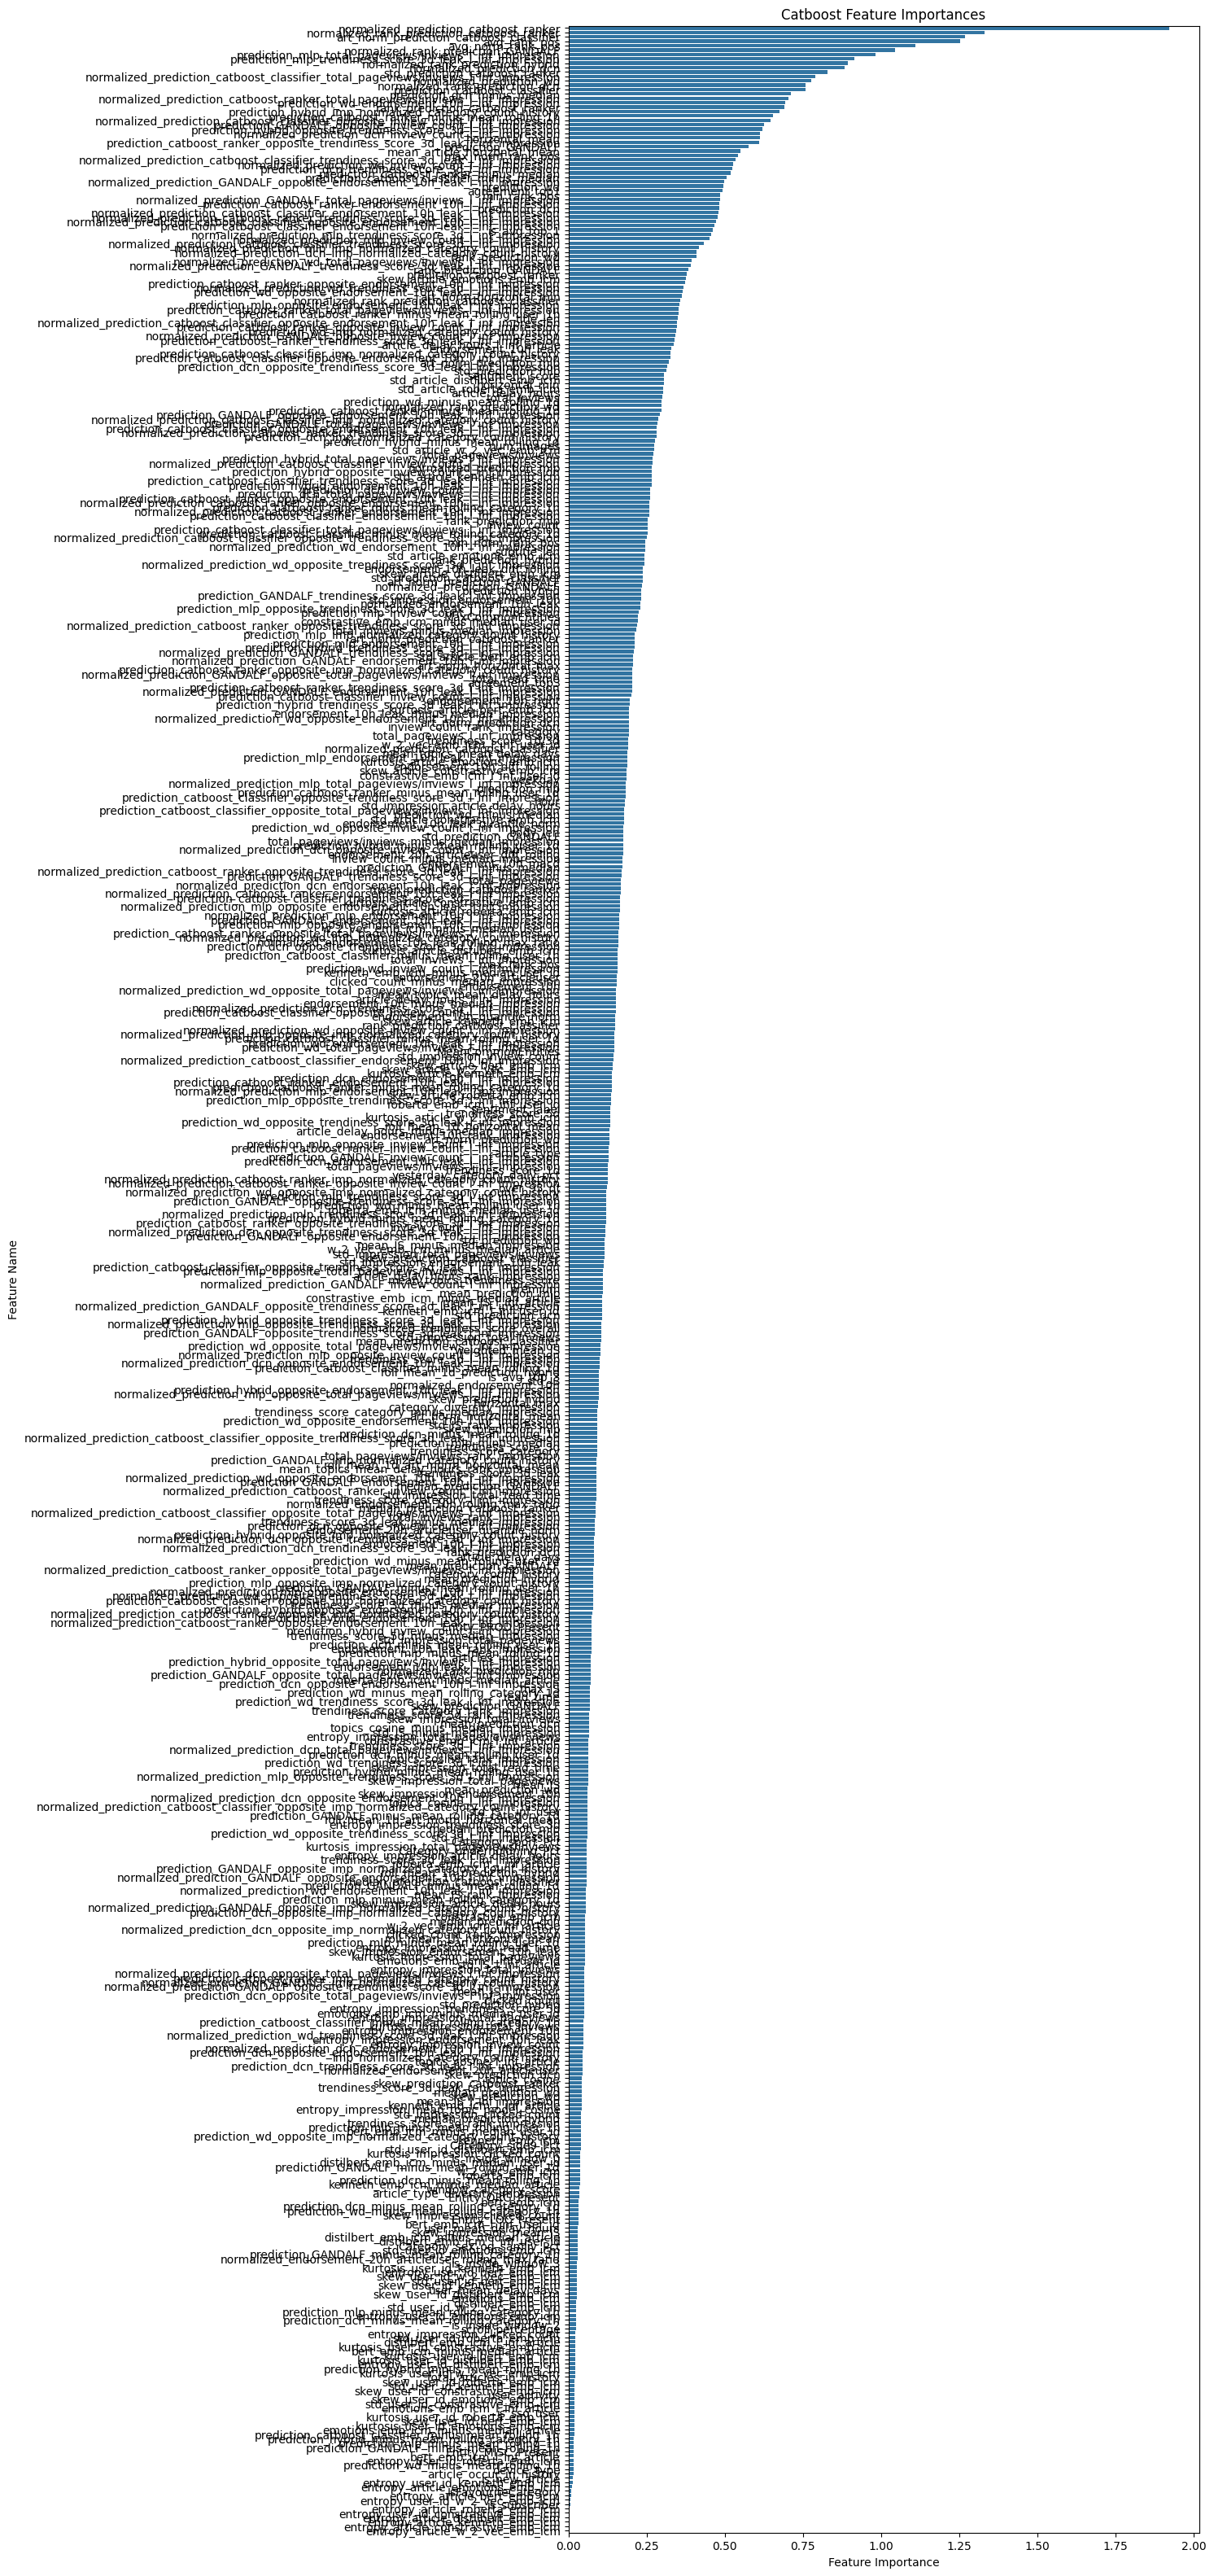

In [79]:
if not RANKER:
    sorted_importances = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 40))
    sns.barplot(x=feature_importances[sorted_importances], y=np.array(X_train.columns)[sorted_importances])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.title('Catboost Feature Importances')

In [80]:
if 'postcode' in level2_val_df.columns:
        level2_val_df = level2_val_df.with_columns(pl.col('postcode').fill_null(5))
if 'article_type' in level2_val_df.columns:
        level2_val_df = level2_val_df.with_columns(pl.col('article_type').fill_null('article_default'))  
if 'impression_time' in level2_val_df.columns:
        level2_val_df = level2_val_df.drop(columns = ['impression_time']) 
        
level2_val_df = level2_val_df.to_pandas()
level2_val_df[categorical_columns] = level2_val_df[categorical_columns].astype('category')

X_val = level2_val_df[X_train.columns]
evaluation_ds = pl.from_pandas(level2_val_df[['impression_id', 'article', 'target']])
    
if RANKER:
    prediction_ds = evaluation_ds.with_columns(pl.Series(catboost.predict(X_val)).alias('prediction'))\
        .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
else : 
    prediction_ds = evaluation_ds.with_columns(pl.Series(catboost.predict_proba(X_val)[:, 1]).alias('prediction'))\
        .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))

/tmp/ipykernel_75682/1757020590.py:6: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  level2_val_df = level2_val_df.drop(columns = ['impression_time'])


In [81]:
cpp_auc = CppAuc()
result = np.mean(
        [cpp_auc.roc_auc_score(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
            for y_t, y_s in zip(prediction_ds['target'].to_list(), 
                                prediction_ds['prediction'].to_list())]
    )
print(result)

0.8246991772661774
